In [1]:
%matplotlib inline 
import torch 
import torch.nn as nn
import torch.distributions as D
import numpy as np
import matplotlib.pyplot as plt

from pyvi.utils import GMMLossFunc as lf
from pyvi.utils import HelperFunc as hf


device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")

print(f"Using {device} device")

plt.style.use('fivethirtyeight')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})


Using cuda device


#  AR(1) state-space model

We consider a AR(1) state process:
\begin{align*}
    y_t|x_t &\sim \mathcal{N}(\alpha + x_t, \sigma_y^2), \quad t=2,\dots, T; \\
    x_t|x_{t-1} &\sim \mathcal{N}(\rho x_{t-1}, \sigma_x^2),\quad t=2,\dots, T;\\
    x_1 &\sim  \mathcal{N}(0, \sigma_{x}^2 / (1-\rho^2))
\end{align*}

The model parameters are $\mathbf{\theta} = (\alpha, \rho, \sigma_x^2, \sigma_y^2)$. We'll start by ignoring the observation noise, i.e we assume $y_t = x_t$ for all $t$.

Let $\tau = 1 / \sigma_x^2$ and $\kappa = \tau  (1 - \rho^2)$ denote the marginal precision of the state $x_t$.

## 1. Simulator

In [2]:
# simulator
def AR1(theta: torch.Tensor, T=100, burn_in=0) -> torch.Tensor:
    '''
    Simulates from an AR(1) process. 

    Input: theta = [alpha, rho, sigma2_x, sigma2_y]
    '''
    x = torch.zeros((theta.size(0), T + burn_in))
    # simulate x0
    x[...,0] = D.Normal(loc=0., scale=(theta[...,2] / (1 - theta[...,1]**2))**(0.5)).sample()
    
    for t in range(1,T + burn_in):
        x[...,t] =  D.Normal(theta[...,1] * x[...,t-1], torch.sqrt(theta[...,2])).sample() 
    
    # simulate observations
    y = D.Normal(theta[...,0] + x.T, torch.sqrt(theta[...,3])).sample()

    return y[burn_in:,].T

### simulation

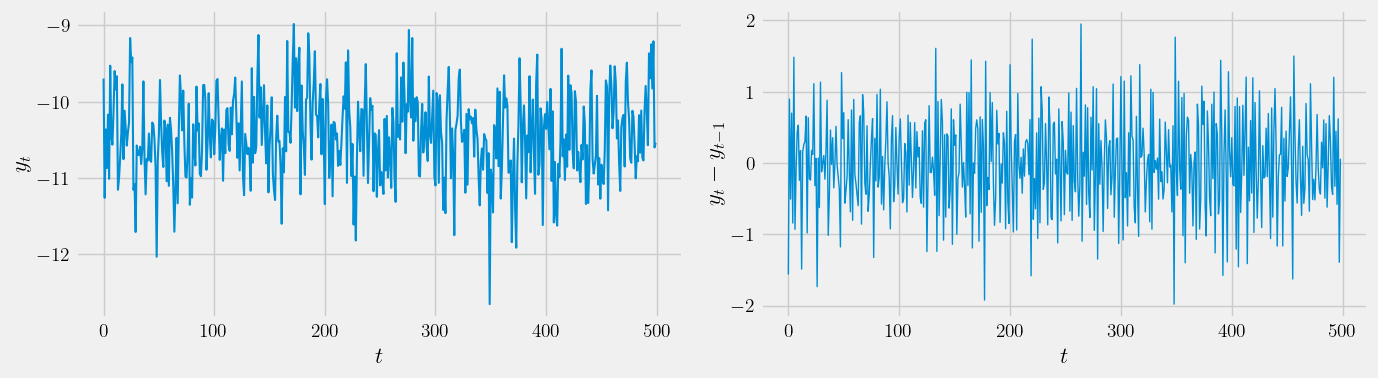

In [3]:
theta = torch.tensor([[-10.4, 0.6, 0.1, 0.2]])
T = 500

y = AR1(theta, T).squeeze()

fig = plt.figure(figsize=(14,4))

fig.add_subplot(121)
plt.plot(torch.arange(T), y, lw=1.5)
plt.xlabel(r'$t$')
plt.ylabel(r'$y_t$')

fig.add_subplot(122)
plt.plot(torch.arange(T-1), y[1:] - y[:(len(y)-1)], lw=1)
plt.xlabel(r'$t$')
plt.ylabel(r'$y_t - y_{t-1}$')

plt.tight_layout()
plt.show()

# 2. Parameter priors

\begin{align*}
    \alpha &\sim \mathcal{N}(0, 0.001^{-1})\\
    \mathrm{logit}(\rho) &\sim \mathcal{N}(0, 0.15^{-1}); \quad \mathrm{logit}(\rho) = \log\left(\frac{1 + \rho}{1 - \rho} \right)\\ 
    \log(\kappa) &\sim \mathrm{logGamma}(1, 5\times 10^{-5})\\
    \log(1/\sigma_y^2) &\sim \mathrm{logGamma}(1, 5\times 10^{-5})\\
\end{align*}

In [4]:
class GaussianInverseGamma():
    def __init__(self, params_alpha, params_logitrho, params_logkappa, params_logprecy):
        
        self.alpha = D.Normal(params_alpha['mean'], params_alpha['sigma'])
        
        self.logitrho = D.Normal(params_logitrho['mean'], params_logitrho['sigma'])

        self.kappa = D.Gamma(params_logkappa['alpha'], params_logkappa['beta'])

        self.precy = D.Gamma(params_logprecy['alpha'], params_logprecy['beta'])
        
        
    def sample(self, shape: torch.Size = ()):
        # fully tranformed scale
        theta_transformed = torch.stack([self.alpha.sample(shape),
                            self.logitrho.sample(shape),
                            self.kappa.sample(shape).log(),
                            self.precy.sample(shape).log()
                            ], dim=-1)  
        
        # natural scale (alpha, rho, sigma2_x, sigma2_y)
        theta = theta_transformed.clone()
        theta[...,1] = (theta[...,1].exp() - 1) / (theta[...,1].exp() + 1)
        theta[...,2] = (1 - theta[...,1]**2) / theta[...,2].exp()
        theta[...,3] = (theta[...,3].exp())**(-1)

        # kappa --> sigma2_x
        # theta_transformed[...,2] = theta[...,2].log()
        # theta_transformed[...,3] = theta[...,3].log()

        return theta, theta_transformed

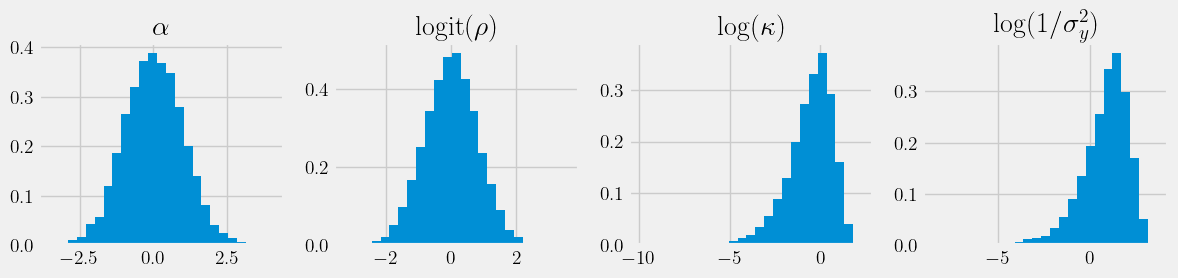

In [5]:
alpha = {'mean': 0.0, 'sigma':1.}
logitrho = {'mean': 0.0, 'sigma': 1.5**(-0.5)}
logkappa = {'alpha': 1.0, 'beta': 1.0}
logprecy = {'alpha': 1.0, 'beta': 1/4}

prior = GaussianInverseGamma(params_alpha=alpha, params_logitrho=logitrho, params_logkappa=logkappa, params_logprecy=logprecy)

N = 10000
theta, theta_transformed =  prior.sample((N,))

fig = plt.figure(figsize=(12, 3))

fig.add_subplot(141)
plt.hist(theta_transformed[...,0], bins=25, density=True)
plt.title(r'$\alpha$')

fig.add_subplot(142)
plt.hist(theta_transformed[...,1], bins=25, density=True)
plt.title(r'$\mathrm{logit}(\rho)$')

fig.add_subplot(143)
plt.hist(theta_transformed[...,2], bins=25, density=True)
plt.title(r'$\log(\kappa) $')

fig.add_subplot(144)
plt.hist(theta_transformed[...,3], bins=25, density=True)
plt.title(r'$\log(1/\sigma_{y}^2) $')

plt.tight_layout()
plt.show()

## 3. Neural Varitional inference: Training the Neural Net

In [6]:
class MultivariateGaussianMDN(nn.Module):
    '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.

    '''
    def __init__(self, input_size:int, dim:int=2, K:int=1, hd:int=64, sort=False):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.sort = sort

        self.hidden = nn.Sequential(          # hidden layers
            #nn.LayerNorm(input_size),
            nn.Linear(input_size, self.hd),
            nn.ReLU(),
            nn.LayerNorm(self.hd),
            nn.Linear(self.hd, self.hd),
            nn.ReLU(),
            nn.LayerNorm(self.hd),
            nn.Linear(self.hd, self.hd),
            nn.ReLU(),
            nn.LayerNorm(self.hd),
            nn.Linear(self.hd, self.hd),
            nn.ReLU(),
            nn.LayerNorm(self.hd)
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )          
    
    def forward(self, x):
        if self.sort:
            x = x.sort().values

        x = self.hidden(x)
        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
    

class ConvNet(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 


        # convolutional layers
        self.conv = nn.Sequential(
            nn.LayerNorm(self.input_size),
            nn.Conv1d(1, 1, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(4),
            #nn.LayerNorm(self.input_size // 4),
            nn.Conv1d(1, 1, 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool1d(2)#,
            #nn.LayerNorm(self.input_size // 8)
        )

        # fully connected (((self.input_size - 4) // 3) - 4) // 2layers
        self.fc = nn.Sequential(
            nn.Linear(self.input_size // 8, self.hd),
            nn.ReLU()#,
            # nn.Linear(self.hd, self.hd),
            # nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):
        # apply convolutional layers
        x = self.conv(x)
        # flatten
        x = x.flatten(1)
        # apply fully-connected layers
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff


class LSTMNet(nn.Module):
     '''
        Multivariate Gaussian Mixture Density Network class for amortized variational inference

        Gaussian mixtures are dense in the space of probability distributions. This motivates their use for posterior density approximation.

        Each mixture is parameterized by the means, Cholesky factors of associated precision matrices and mixture weights.

        The neural network does not output the Cholesky factors directly but rather tensors containing their respective lower diagonal elements.
    '''
     def __init__(self, input_size, dim:int=2, K:int=1, hd:int=64):
        '''
            Input: 
                * input_size: dimension of the input to the neural net, i.e. the number of elements in the observation vector yobs
                * dim:        dimension of the posterior distribution. This is in general the number of parameters in the model.
                * K:          number of mixture components
                * hd:     dimension of hidden layers
            Output:
                * mean: tensor of dimensions batchsize X k X dim containing the predicted means
                * chol: tensor of appropriate dimensions containing the the predicted Cholesky factors
                * coeff: tensor of appropriate dimensions containing the predicted mixture component weights
        '''
        super().__init__()

        self.dim = dim
        self.K = K
        self.hd = hd
        self.input_size = input_size 

        # lstm layer
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hd, num_layers=1, batch_first=True)

        # fully connected hidden layer
        self.fc = nn.Sequential(
            nn.Linear(self.hd, self.hd),
            nn.ELU()
        )
        
        # means of each component
        self.mean = nn.Linear(self.hd, self.K * self.dim)
        
        # Cholesky factors of the precision matrices (diagonal elements are log-scaled)
        self.chol = nn.Linear(self.hd, self.K * self.dim * (self.dim + 1) // 2)

        # mixture weights, non-negative and summing to 1
        self.coeff = nn.Sequential(
            nn.Linear(self.hd, self.K),
            nn.Softmax(dim=1)   
            )  

        
     def forward(self, x):
        # lstm & hidden layers
        x, _ = self.lstm(x)
        x = x[:,-1,:]   # extract final time step
        x = self.fc(x)

        # mean
        mean = self.mean(x)
        mean = mean.reshape((mean.shape[0], self.K, self.dim))

        # Cholecky factor
        chol = self.chol(x)
        chol = chol.reshape((chol.shape[0], self.K, self.dim * (self.dim + 1) // 2))

        # mixture weights
        if self.K > 1:
            coeff = self.coeff(x)
        else:
            coeff = torch.ones(1)
        
        return mean, chol, coeff
        
    


### Training

In [7]:
def transform_data(data, period_length):
    dataset = data.clone()
    dataset[...,1:] = data[...,1:] - data[...,:-1]
    #dataset = (dataset - dataset.mean(dim=0).unsqueeze(1)) / dataset.std(dim=-1).unsqueeze(1)
    Y = []

    for i in range(dataset.size(1) // period_length):
        period = dataset[...,i*period_length:(i*period_length + period_length)]
        Y.append(period)
    
    return torch.stack(Y, dim=1)

Epoch 1 Loss 5.293529192769528 

Epoch 2 Loss 4.420052673017978 

Epoch 3 Loss 4.085881545627117 

Epoch 4 Loss 3.861241366994381 

Epoch 5 Loss 3.688397898387909 

Epoch 6 Loss 3.5155790388911963 

Epoch 7 Loss 3.2816155563771723 

Epoch 8 Loss 2.9590101591488813 

Epoch 9 Loss 2.5708078673311974 

Epoch 10 Loss 2.349946778673539 

Epoch 11 Loss 2.1718725498091893 

Epoch 12 Loss 2.0731558049418264 

Epoch 13 Loss 1.9879076156590716 

Epoch 14 Loss 1.887687290924124 

Epoch 15 Loss 1.8501427745989698 

Epoch 16 Loss 1.7977656532522057 

Epoch 17 Loss 1.701145052805502 

Epoch 18 Loss 1.6337912831139751 

Epoch 19 Loss 1.5841437647771426 

Epoch 20 Loss 1.5623577000407385 

Epoch 21 Loss 1.5396307009282055 

Epoch 22 Loss 1.4776333500306356 

Epoch 23 Loss 1.412637304833284 

Epoch 24 Loss 1.376259047528298 

Epoch 25 Loss 1.3611325165196277 

Epoch 26 Loss 1.3095687618588738 

Epoch 27 Loss 1.2518454843885847 

Epoch 28 Loss 1.2242935446130578 

Epoch 29 Loss 1.199336159272206 

Epoch

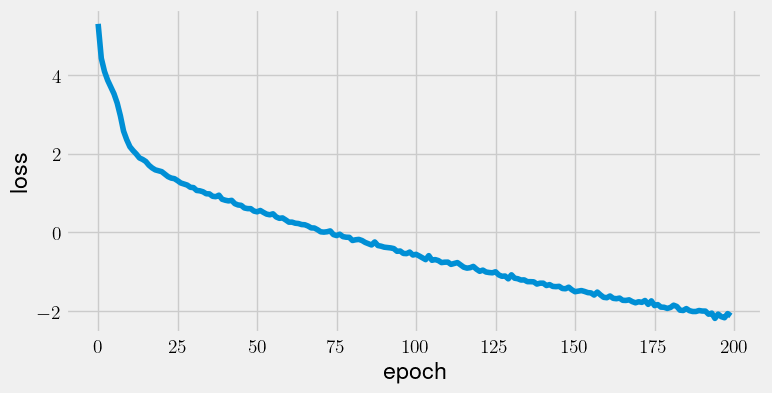

In [8]:
#Explicitly provided seeds for training process
random_seed = 1234
torch.manual_seed(random_seed)

cuda = torch.cuda.is_available()
if cuda:
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

#========================================== 
#           generating training data
#==========================================
n_prior, n_obs, period_length, batchsize = 10000, 100, 20, 200

# sample parameter values from the specified prior
Theta_train, Theta_tranformed_train =  prior.sample((n_prior,))

# standardize alpha
mean_param, std_param =  Theta_tranformed_train.mean(dim=0), Theta_tranformed_train.std(dim=0)
Theta_tranformed_train = (Theta_tranformed_train - mean_param) / std_param


# draw samples from the simulator conditioned on parameter values
Y_train = AR1(Theta_train, n_obs, burn_in=0)
Y_train = transform_data(Y_train, period_length=period_length)

# create a combined dataset and data loader
data_train = torch.utils.data.TensorDataset(Y_train, Theta_tranformed_train)
data_loader = torch.utils.data.dataloader.DataLoader(data_train, batch_size=batchsize, shuffle=True)

# Neural net
gmmnet = LSTMNet(input_size=period_length, dim=4, K=2, hd=128).to(device)
loss_fn = lf.GaussianMixtureLoss(aggr='mean')

# # train DNN model
gmmnet = hf.nn_optimizer(model=gmmnet, 
                       data_loader=data_loader,
                       loss_fn=loss_fn,
                       learning_rate=1e-3,
                       eps=0.004, 
                       max_epochs=200,
                       verbose=True,
                       echo_after=1,
                       path='trained_models/ar/ar_lstm_inla_1.pt'
                      )

#gmmnet = torch.load('trained_models/ar/ar_lstm_1.pt')

## 4. Posterior distribution

In [12]:
labels = [r'$\alpha$', r'$\mathrm{logit}(\rho)$', r'$\log(\kappa) $', r'$\log(1/\sigma_{y}^2) $']

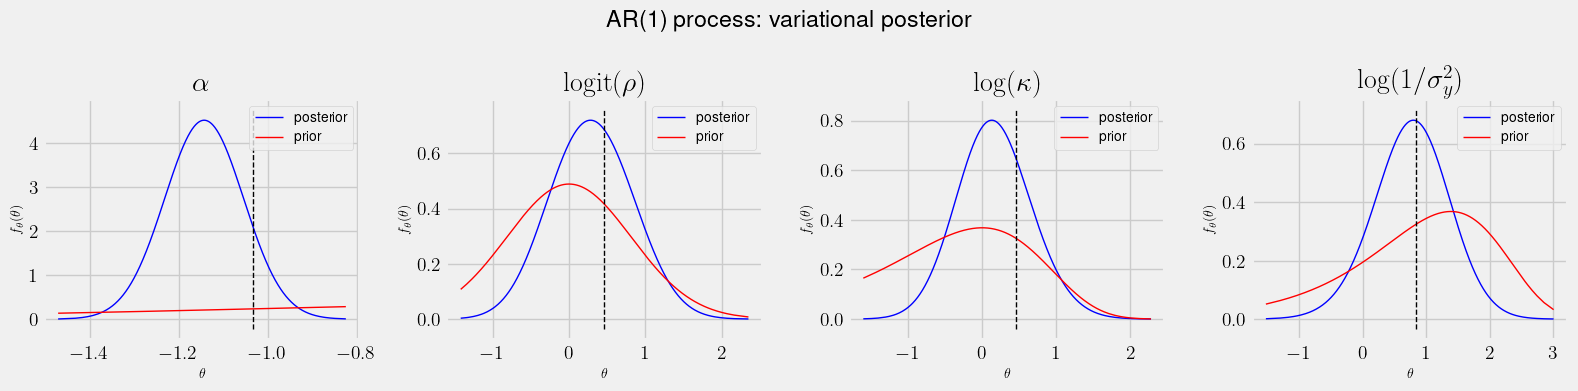

In [13]:
theta, theta_transformed = prior.sample((1,))
T = n_obs

y = AR1(theta, T)
y_d  = y.clone()
y = transform_data(y, period_length=period_length)

# run the gmmnet
with torch.no_grad():
    mean, chol, coeff = gmmnet(y.to(device))

n_sim, n_component, dim = mean.shape[0], mean.shape[1], mean.shape[2]

# calculate Cholesky factors
chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

# # caclulate precision matrices
precision = chol @ chol.transpose(2, 3)

# # calculate covariance matrices
covariance = torch.linalg.inv(precision) 

# mixture weights
mix = D.Categorical(coeff)

N = 10000
# prior values
_, prior_vals = prior.sample((N,))

# plotting
fig = plt.figure(figsize=(16, 4))

for k in range(dim):
    # mixture components
    comp = D.Normal(loc=mean[:,:,k], scale=torch.sqrt(covariance[:,:,k,k]))
    # define the mixture
    gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,k].squeeze(), torch.sqrt(covariance[:,:,k,k]).squeeze())
    

    # draw samples from the approximate posterior
    theta_k_sd = gmm.sample((N,)).squeeze().sort().values 
    theta_k = (theta_k_sd * std_param[k] + mean_param[k]).cpu().sort().values      # put on unnormalized scale
    pdf = gmm.log_prob(theta_k_sd).exp().cpu() / std_param[k]
    

    # true value
    theta_k_true = theta_transformed[:,k]

    # prior
    theta_k_prior = prior_vals[...,k].sort().values
    if k == 0:
        pdf_prior = prior.alpha.log_prob(theta_k).exp() 
    elif k == 1:
        pdf_prior = prior.logitrho.log_prob(theta_k).exp()
    elif k == 2:
        theta_inv = theta_k.exp()
        pdf_prior = prior.kappa.log_prob(theta_inv).exp() * abs(theta_inv)
    elif k == 3:
        theta_inv = theta_k.exp()
        pdf_prior = prior.precy.log_prob(theta_inv).exp() * abs(theta_inv)
    
    
    fig.add_subplot(1, dim, k+1)
    plt.plot(theta_k, pdf, lw=1., c='b', label='posterior')
    plt.plot(theta_k, pdf_prior, lw=1., c='r', label='prior')
    plt.vlines(x=theta_k_true, ymin=plt.axis()[2], ymax=plt.axis()[3], linestyles='dashed', colors='black', lw=1)
    
    plt.xlabel(r'$\theta$', fontsize=10)
    plt.ylabel(r'$f_\theta(\theta)$', fontsize=10)
    plt.legend(fontsize=10)
    plt.title(labels[k])

plt.suptitle('AR(1) process: variational posterior')
plt.tight_layout()
plt.show()

### Simulation-based calibration check

In [ ]:
def sbc_gaussian(gmmnet, proposal, n_sim = 1e+4, ecdf=True, ecdf_diff=False, logscale=None, labels=None):
    '''
    Perform simulation-based calibration check for a Gaussian mixture network for posterior approximation

    Input:
        -- gmmnet: Gaussian mixture network, with input size given by `sample_size`
        -- proposal: proposal distribution `theta ~ p(theta)`, usually the same as the prior/proposal distribution used for training
                     Note: must have a `sample()` method
        
        -- generator: function that takes parameter values `theta` as input and generate the corresponding simulator model
                       `x ~ p(x|theta)`  as an instance of a class with a `sample` method
        
        -- sample_size: number of iid samples from `x ~ p(x|theta)` for each values of theta

        -- n_sim: number of simulation from the joint distribution: theta ~ p(theta); x ~ p(x|theta)

        -- ecdf: whether to output an eCDF or a histogram plot, default: ecdf=True

        -- ecdf_diff: whether on the y-axis are the `ecdf(w)` values (if True) or `ecdf(w) - w` values (if False).
                        This is ignored if ecdf=False.
        
        -- logscale: (iterable) contains dimensions of the model parameter vector `theta` that are on log-scale
                        note: we use the standard Python counting, starting at 0

    Note: 95% confidence intervals are based on the  Dvoretzky–Kiefer–Wolfowitz inequality (see https://en.wikipedia.org/wiki/Empirical_distribution_function, accessed: 20-05-2024)
    
    Output: SBC plot as a Pyplot figure
    '''
    # draw samples from the prior/proposal  theta ~ p(theta)
    Theta, Theta_tranformed = proposal.sample((n_sim,))

    # draw samples from the model x ~ p(x|theta)
    X = AR1(Theta, n_obs)
    X = transform_data(X, period_length=period_length)
    # ensure all dimensions are on the right scale
    # Theta[:,1] = (1 + Theta[:,1]).log() - (1 - Theta[:,1]).log()

    # if logscale:
    #     for i in logscale:
    #         Theta[:,i] = Theta[:,i].log()     # put sigma2 on logscale
    Theta_tranformed = (Theta_tranformed - mean_param) / std_param
    Theta = Theta_tranformed.clone()
    
    # run the gmmnet
    with torch.no_grad():
        mean, chol, coeff = gmmnet(X.to(device))

    n_component, dim = mean.shape[1], mean.shape[2]

    # calculate Cholesky factors
    chol = torch.vmap(lf.exp_diagonal)(lf.to_triangular(chol.view(n_sim * n_component,  dim * (dim + 1) // 2), dim)).view(n_sim, n_component, dim, dim)

    # caclulate precision matrices
    precision = chol @ chol.transpose(2, 3)

    # calculate covariance matrices
    covariance = torch.linalg.inv(precision) 

    # define GMM variational marginal distributions and calculate cdf values for the true parameter values
    
    fig = plt.figure(figsize=(12, 3))

    for j in range(dim):
        # mixture weights
        mix = D.Categorical(coeff)
        # mixture components
        comp = D.Normal(mean[:,:,j], torch.sqrt(covariance[:,:,j,j]))
        # define the mixture
        gmm = D.MixtureSameFamily(mix, comp) if n_component > 1 else D.Normal(mean[:,:,j].squeeze(), torch.sqrt(covariance[:,:,j,j]).squeeze())
        # evaluate cdf
        w = gmm.cdf(Theta[:,j].to(device)).cpu().squeeze()

        if ecdf:
            #=====================================================
            # ECDF plot
            #=====================================================
            # Calculate the empirical cumulative distribution function (ECDF)
            eCDF = torch.arange(1, n_sim + 1) / n_sim

            # calculate 95% confidence intervals for the eCDF
            eps = np.sqrt(np.log(2 / 0.05) / (2 * n_sim))
            eCDF_lower, eCDF_upper = eCDF - eps, eCDF + eps

            # exact cdf
            x = np.linspace(0, 1, 100)
            w = w.sort().values

            fig.add_subplot(1, dim, j+1)
            if not ecdf_diff:
                # plot eCDF and true CDF values
                plt.step(w, eCDF, lw=1)
                plt.plot(x, x, 'k--', lw=1)
                # plot 95% confidence bands
                plt.fill_between(w, eCDF_lower, eCDF_upper, color='red', alpha=0.2)
                plt.ylabel(r'$F_{\omega}$')
            else:
                plt.step(w, eCDF - w, lw=1)
                #plt.fill_between(w, eCDF_lower - w, eCDF_upper - w, color='red', alpha=0.1)
                plt.ylabel(r'$F_{\omega} - \omega$')

            plt.xlabel(r'$\omega$')
            plt.title(labels[j])
        else:
            #========================================
            # plot histograms
            #========================================
            fig.add_subplot(1, dim, j + 1)
            plt.hist(w, bins=25, density=True, alpha=.6)
            plt.title(labels[j])

    plt.tight_layout()
        
    
    return fig

In [ ]:
f = sbc_gaussian(gmmnet, prior, 10000, ecdf=True, ecdf_diff=False, logscale=[2,3], labels=labels)